In [1]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib.animation import FuncAnimation
import geopandas as gpd


import threedigrid
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin

import uuid

In [2]:
from __my_functions_flooddepth_houses import get_time_dimensions_flood
from __my_functions_flooddepth_houses import create_df_flooddepth_houses
from __my_functions_flooddepth_houses import create_sample_houses_withinZone
from __my_functions_flooddepth_houses import calculate_first_qth_arrival_and_maxdepth
from __my_functions_flooddepth_houses import plot_flooddepth_houses_in_zone

from __my_functions import get_minutes_from_start_flood

-----------

### paths

In [3]:
## flood results paths
# floodresults_path = '/Users/louiseklingen/Documents/TU/modelresults/modelresults_denhelder' 
floodresults_path = 'E:/projecten/P2019_1_DenHelderOverstroming/data_en_modellen/modelresults' 

In [4]:
general_path = 'E:/paper2_analysis/depth_arrival_zones'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

-----------------------------------

### laod result 

In [50]:
# scenario_name = 'scen2_napiek'
nr_zones_sampling = 89
samplesize_nr_houses_in_zone = 50


scenario_name = 'scen1_voorpiek'
simulation_name = 'lk_dh_test13_5verloop_2d'
## start_breach_time = '2000-01-01T18:00:00'
# start_breach_time = '2000-01-01T00:00:00'


# scenario_name = 'scen2_napiek'
# simulation_name = 'lk_dh_test14_5verloop_38h'
# # start_breach_time = '2000-01-02T04:00:00'
# start_breach_time = '2000-01-01T00:00:00'


start_breach_time_obj = datetime.strptime(start_breach_time, '%Y-%m-%dT%H:%M:%S')

In [51]:
zones_maxdepth_arrival_df = gpd.read_file(f'{output_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses.geojson')
zones_maxdepth_arrival_df.head(2)


,BU_NAAM,AANT_INW,maxdepth,maxdepth_qt,arrival,geometry
0,Boerderijbuurt,1110,2.397723,2.367502,2000-01-01 01:05:03,"POLYGON ((113433.000 550215.813, 113452.500 55..."
1,Tuindorp-West,1685,2.943293,2.873900,2000-01-01 00:30:03,"POLYGON ((112958.898 551878.625, 112937.602 55..."


In [52]:
## flood result files
netcdf_file = (f'{floodresults_path}/{simulation_name}/results_3di.nc')
gridadmin_file = (f'{floodresults_path}/{simulation_name}/gridadmin.h5')
gr = GridH5ResultAdmin(gridadmin_file , netcdf_file)
ga = GridH5Admin(gridadmin_file)
time_humanized, last_timestamp  = get_time_dimensions_flood(gr, start_breach_time)

rekentijd: 48.00278541015558 uur
aantal tijdstappen: 577
interval: 300.05, secondes = 5.0 min
 breach start time at: 2000-01-01 00:00:00


------------

<AxesSubplot:>

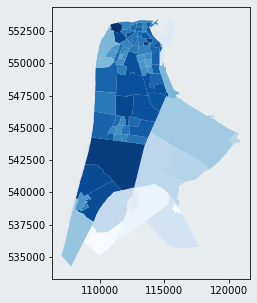

In [53]:
fig = plt.figure(figsize=(20, 5),facecolor='#e9ecef')
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('#e9ecef')


# zones_maxdepth_arrival_df.plot(ax=ax, column = 'arrival', cmap= 'YlOrRd_r')
zones_maxdepth_arrival_df.plot(ax=ax, column = 'maxdepth', cmap= 'Blues')


## drop nan values and add minutes from start

In [54]:
zones_maxdepth_arrival_df_dropna = zones_maxdepth_arrival_df.dropna()

zones_maxdepth_arrival_df_clean = zones_maxdepth_arrival_df_dropna.copy()
zones_maxdepth_arrival_df_clean['minutes'] = np.nan

for index, row in zones_maxdepth_arrival_df_clean.iterrows():
    timestep_str = row.arrival
    if len(timestep_str) != 0:
        minutes_from_start = get_minutes_from_start_flood(start_breach_time_obj, timestep_str)
        zones_maxdepth_arrival_df_clean.loc[index, 'minutes'] =  minutes_from_start


a timestamp skipped due to error in notation
a timestamp skipped due to error in notation
a timestamp skipped due to error in notation


In [55]:
zones_maxdepth_arrival_df_clean.head(2)

,BU_NAAM,AANT_INW,maxdepth,maxdepth_qt,arrival,geometry,minutes
0,Boerderijbuurt,1110,2.397723,2.367502,2000-01-01 01:05:03,"POLYGON ((113433.000 550215.813, 113452.500 55...",65.0
1,Tuindorp-West,1685,2.943293,2.873900,2000-01-01 00:30:03,"POLYGON ((112958.898 551878.625, 112937.602 55...",30.0


### flood depth threshold

In [63]:
df = zones_maxdepth_arrival_df_clean

time_ = 60 #min
depth_ = 1.5

# zones above depth threshold
zones_thr_maxdepth = df[df.maxdepth > depth_]

#zones above depths and time threshold
zones_thr_maxdepth_and_time =  df[(df.maxdepth > depth_) &  (df.minutes > time_)]

#zone before time thrshold and above depth trheshold
zones_thr_maxdepth_before_time =  df[(df.maxdepth > depth_) &  (df.minutes < time_)]

### export to geojson

In [64]:
# export to geojson
zones_thr_maxdepth.to_file(f'{output_path}/zones_thrs_depth_{scenario_name}_sample{samplesize_nr_houses_in_zone}houses_tresh_{depth_}m.geojson')
zones_thr_maxdepth_and_time.to_file(f'{output_path}/zones_thrs_depth_time_{scenario_name}_sample{samplesize_nr_houses_in_zone}houses_tresh_{depth_}m_{time_}min.geojson')


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [59]:
zones_thr_maxdepth_and_time.AANT_INW.sum()

46500

-------------

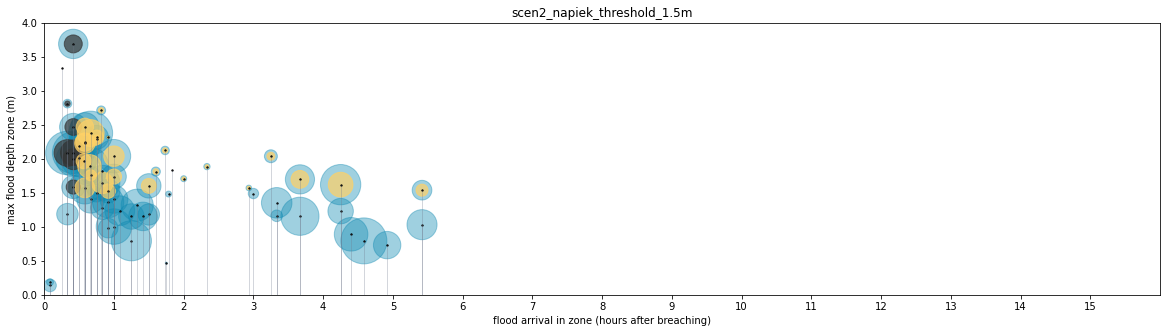

In [145]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 1, 1)

df = zones_maxdepth_arrival_df_clean.copy()
df_d_t = zones_thr_maxdepth_and_time.copy()
df_d_bt = zones_thr_maxdepth_before_time.copy()

ax.vlines(df.minutes/60, 0, df.maxdepth, linewidth= 1, color = '#70798c', alpha=0.3)
ax.scatter(df.minutes/60, df.maxdepth,s = df.AANT_INW*0.8, alpha= 0.4, color = '#118ab2' )

# above threshold, before time
ax.scatter(df_d_bt.minutes/60, df_d_bt.maxdepth,s = df_d_bt.AANT_INW*0.3, alpha=0.7 , color= '#353535')

# above threshold after time
ax.scatter(df_d_t.minutes/60, df_d_t.maxdepth,s = df_d_t.AANT_INW*0.3, alpha=0.7 , color= '#ffd166')

# black point
ax.scatter(df.minutes/60, df.maxdepth,s = 1.7, alpha=1, c ='k' )

max_hours = 16
ax.set_ylim(0, 4)
ax.set_xlim(0, max_hours)
ax.set_title(f'zones_maxdepth_arrival_df_{scenario_name}') 
plt.xlabel('flood arrival in zone (hours after breaching)')
plt.ylabel('max flood depth zone (m)')
plt.xticks(np.arange(0, max_hours))

plt.title(f'{scenario_name}_threshold_{depth_threshold}m')
plt.savefig(f'{figures_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses_tr{depth_}m_{time_}min.png', dpi=300)  
# plt.savefig(f'{figures_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}.svg', dpi=300)  